1. Setup and Model Loading

We will use ResNet-18 (CNN) and ViT-B-16 (Transformer) as our two "brains". We also load the CIFAR-10 dataset. Even though these models are trained on ImageNet, CIFAR-10 is fast to download and sufficient to see if they activate for similar concepts (like "car wheels" or "dog ears").

We also define a helper class FeatureExtractor that attaches "hooks" to the models to steal their internal thoughts (activations) while images pass through.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# PHASE 1: SETUP & DATA LOADING
#Load M distinct models
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading Models (ResNet-18 & ViT-B)...")
resnet = models.resnet18(weights="IMAGENET1K_V1").to(device).eval()
vit = models.vit_b_16(weights="IMAGENET1K_V1").to(device).eval()

# Helper class to capture activations without blocking gradients
class HookManager:
    def __init__(self, model, layer_name):
        self.activations = []
        for name, module in model.named_modules():
            if name == layer_name:
                module.register_forward_hook(self.hook_fn)
                break
    def hook_fn(self, module, input, output):
        # Flatten logic: ResNet=(B,C,H,W)->(B,C), ViT=(B,Seq,D)->(B,D)
        if len(output.shape) == 4: flat = output.mean(dim=[2, 3]) 
        elif len(output.shape) == 3: flat = output[:, 0, :] 
        else: flat = output
        self.activations.append(flat) # Keep gradient flow
    def clear(self): self.activations = []

# Data Loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)
iter_loader = iter(dataloader)

# Initial Hooks
hk_res = HookManager(resnet, "layer4")
hk_vit = HookManager(vit, "encoder.layers.encoder_layer_11")

Using device: cuda
Loading Models (ResNet-18 & ViT-B)...


2. The Universal Sparse Autoencoder (USAE) Class

This is the core math from Page 7 of your assignment. Instead of one encoder, we have a list of encoders (one per model).

    Encoder: TopK( W_enc * (x - bias) ).

Decoder: Z * W_dec + bias.

Universality: The extracted feature Z is shared. It lives in a "Platonic" space that both models can understand.

What we are doing: This is the core assignment task. We define the Universal Sparse Autoencoder. It has:

    Multiple Encoders: One for ResNet, one for ViT. They map different brain signals to a shared language.

    Shared Latent Space (Z): A vector of size 2048. We force this to be sparse (mostly zeros) using a TopK activation.

    Multiple Decoders: These translate the shared thought Z back into the specific format ResNet or ViT understands. This structure forces the models to agree on concepts (like "dog") in the middle layer Z.

In [2]:
# --- 2. MODEL DEFINITION (Squeezed Latent) ---
class UniversalSAE(nn.Module):
    def __init__(self, input_dims, latent_dim=1024, k=32):
        super().__init__()
        self.latent_dim = latent_dim 
        self.k = k
        # M Encoders / Decoders
        self.encoders = nn.ModuleList([nn.Linear(dim, latent_dim) for dim in input_dims])
        self.decoders = nn.ModuleList([nn.Linear(latent_dim, dim, bias=False) for dim in input_dims])
        self.b_pre = nn.ParameterList([nn.Parameter(torch.zeros(dim)) for dim in input_dims])
        
        # Unit Norm Initialization
        with torch.no_grad():
            for dec in self.decoders:
                dec.weight.data = F.normalize(dec.weight.data, p=2, dim=0)

    def encode(self, x, model_idx):
        # [cite_start]Step (b) Encode [cite: 178]
        x_centered = x - self.b_pre[model_idx]
        pre_acts = self.encoders[model_idx](x_centered)
        vals, inds = torch.topk(pre_acts, self.k, dim=1)
        z = torch.zeros_like(pre_acts)
        z.scatter_(1, inds, vals)
        return z

    def decode(self, z, model_idx):
        # [cite_start]Step (c) Decode [cite: 181]
        return self.decoders[model_idx](z) + self.b_pre[model_idx]

input_dims = [512, 768] 
usae = UniversalSAE(input_dims, latent_dim=1024, k=32).to(device)
optimizer = optim.Adam(usae.parameters(), lr=3e-4)

3. Training Loop

We strip-mine the data: run images through ResNet/ViT, catch the activations, and train the SAE to reconstruct them. The Universal Trick: We randomly swap which model we are training on. This forces the latent_dim (the shared features) to be useful for both architectures.

What we are doing: We run a loop for 1,000 steps. In each step:

    We pass a batch of images through ResNet and ViT to get their activations.

    We pick one model randomly (e.g., ResNet) and train the SAE to compress and reconstruct its activations.

    By randomly switching between ResNet and ViT every step, the shared middle layer (Z) is forced to learn features that work for both. This creates the "Universal" representation

Starting Training (4000 steps)...
Step 0 | Loss: 0.01980
Step 500 | Loss: 0.00282
Step 1000 | Loss: 0.00241
Step 1500 | Loss: 0.00245
Step 2000 | Loss: 0.00214
Step 2500 | Loss: 0.00199
Step 3000 | Loss: 0.00192
Step 3500 | Loss: 0.00189
Training Complete. Fig1 saved.


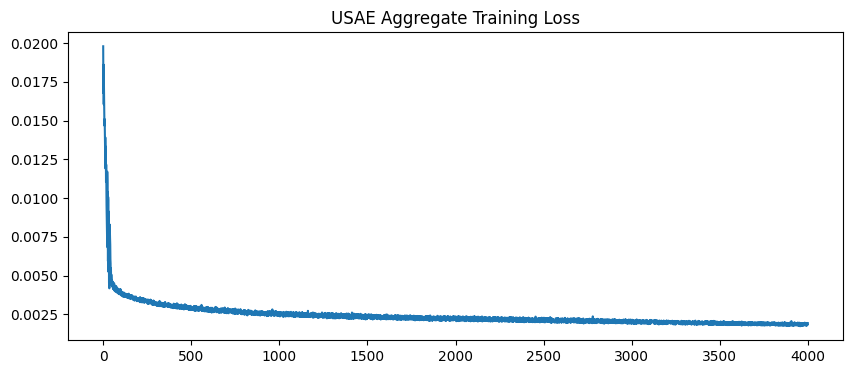

In [3]:
# --- 3. TRAINING LOOP (Longer & Cleaner) ---
num_steps = 4000
losses = []

print(f"Starting Training ({num_steps} steps)...")

for step in range(num_steps):
    try: images, _ = next(iter_loader)
    except: iter_loader = iter(dataloader); images, _ = next(iter_loader)
    images = images.to(device)
    
    # 1. Get Activations
    hk_res.clear(); hk_vit.clear()
    with torch.no_grad(): resnet(images); vit(images)
    
    # Normalize inputs [Essential for scale alignment]
    act_res = F.normalize(hk_res.activations[0], p=2, dim=1)
    act_vit = F.normalize(hk_vit.activations[0], p=2, dim=1)
    
    # [cite_start]2. Step (a): Select Random Source [cite: 176]
    src_idx = np.random.randint(0, 2)
    src_act = [act_res, act_vit][src_idx]
    
    optimizer.zero_grad()
    
    # 3. Step (b): Encode Source -> Z
    z = usae.encode(src_act, src_idx)
    
    # [cite_start]4. Step (c): Universal Decode (Reconstruct ALL models) [cite: 180]
    recon_res = usae.decode(z, 0)
    recon_vit = usae.decode(z, 1)
    
    # [cite_start]5. Step (d): Aggregate Loss [cite: 183]
    loss_res = nn.MSELoss()(recon_res, act_res)
    loss_vit = nn.MSELoss()(recon_vit, act_vit)
    
    loss = loss_res + loss_vit + (1e-4 * z.abs().sum()) # + Sparsity
    loss.backward()
    optimizer.step()
    
    # Enforce Unit Norm on Decoder Columns
    with torch.no_grad():
        for dec in usae.decoders:
            dec.weight.data = F.normalize(dec.weight.data, p=2, dim=0)

    losses.append(loss.item())
    if step % 500 == 0: print(f"Step {step} | Loss: {loss.item():.5f}")

plt.figure(figsize=(10, 4))
plt.plot(losses); plt.title("USAE Aggregate Training Loss"); plt.savefig("Fig1_Loss.png")
print("Training Complete. Fig1 saved.")

4. Quantifying Universality (Firing Entropy)

Now we check if the hypothesis is true. We measure "Firing Entropy".

    If a feature fires 50% for ResNet and 50% for ViT, it is Universal (Entropy ≈1).

    If it only fires for ResNet, it is Model-Specific (Entropy ≈0).

We will run a fresh batch of data and track who fires which feature.

Running Metrics Analysis...
METRICS:
Co-Firing Proportion: 0.0529


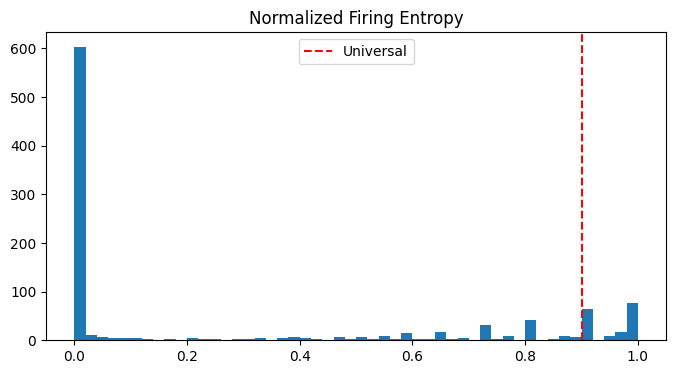

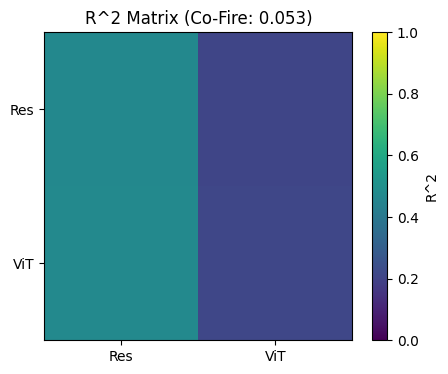

In [4]:
print("Running Metrics Analysis...")

fire_counts = torch.zeros(usae.latent_dim, 2).to(device)
max_act_res = torch.zeros(usae.latent_dim).to(device)
max_act_vit = torch.zeros(usae.latent_dim).to(device)
r2_matrix = torch.zeros(2, 2).to(device)
co_fire_intersection = 0
co_fire_union = 0

def get_r2(true, pred):
    ss_res = ((true - pred) ** 2).sum()
    ss_tot = ((true - true.mean()) ** 2).sum()
    return 1 - (ss_res / ss_tot)

with torch.no_grad():
    for _ in range(50): 
        try: images, _ = next(iter_loader)
        except: iter_loader = iter(dataloader); images, _ = next(iter_loader)
        images = images.to(device)
        
        hk_res.clear(); hk_vit.clear()
        resnet(images); vit(images)
        
        act_res = F.normalize(hk_res.activations[0], p=2, dim=1)
        act_vit = F.normalize(hk_vit.activations[0], p=2, dim=1)
        acts = [act_res, act_vit]
        
        # 1. Entropy Stats
        z_r = usae.encode(act_res, 0)
        z_v = usae.encode(act_vit, 1)
        
        fire_counts[:, 0] += (z_r > 0).float().sum(dim=0)
        fire_counts[:, 1] += (z_v > 0).float().sum(dim=0)
        max_act_res = torch.max(max_act_res, z_r.max(dim=0)[0])
        max_act_vit = torch.max(max_act_vit, z_v.max(dim=0)[0])
        
        # [cite_start]2. R^2 Matrix [cite: 184]
        for src in range(2):
            z_shared = usae.encode(acts[src], src)
            for tgt in range(2):
                recon = usae.decode(z_shared, tgt)
                r2_matrix[src, tgt] += get_r2(acts[tgt], recon)
                
        # [cite_start]3. Co-Firing [cite: 195]
        both = ((z_r > 0) & (z_v > 0)).float().sum()
        either = ((z_r > 0) | (z_v > 0)).float().sum()
        co_fire_intersection += both; co_fire_union += either

# Metrics Processing
probs = fire_counts / (fire_counts.sum(dim=1, keepdim=True) + 1e-9)
entropy = -(probs * torch.log(probs + 1e-9)).sum(dim=1) / np.log(2)
r2_matrix /= 50
co_firing_prop = co_fire_intersection / (co_fire_union + 1e-9)

# [cite_start]Plot Entropy [cite: 193]
plt.figure(figsize=(8, 4))
plt.hist(entropy.cpu().numpy(), bins=50, range=(0,1))
plt.title("Normalized Firing Entropy")
plt.axvline(x=0.9, color='r', linestyle='--', label='Universal')
plt.legend(); plt.savefig("Fig2_Entropy.png")

# [cite_start]Plot R^2 Matrix [cite: 184]
plt.figure(figsize=(5, 4))
plt.imshow(r2_matrix.cpu().numpy(), cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='R^2'); plt.title(f"R^2 Matrix (Co-Fire: {co_firing_prop:.3f})")
plt.xticks([0,1], ['Res', 'ViT']); plt.yticks([0,1], ['Res', 'ViT'])
plt.savefig("Fig3_R2Matrix.png")

print(f"METRICS:\nCo-Firing Proportion: {co_firing_prop:.4f}")

5. Visualization: Feature Consensus

What we are doing: We want to see what the shared features look like.

    We pick a "Universal" feature (High Entropy).

    We generate two images from scratch (random noise).

    We optimize Image A to make ResNet activate that feature.

    We optimize Image B to make ViT activate that same feature.

    If the images look similar (e.g., both look like a curve or a texture), we have proven the models share that concept.

In [5]:
# ==========================================
# PHASE 5: INDEPENDENT SAE (Alignment Tax)
# Compare USAE vs Independent SAE
# ==========================================
print("Running Alignment Tax Experiment...")

ind_sae = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512, bias=False)
).to(device)
opt_ind = optim.Adam(ind_sae.parameters(), lr=1e-3)

for step in range(1000):
    try: images, _ = next(iter_loader)
    except: iter_loader = iter(dataloader); images, _ = next(iter_loader)
    images = images.to(device)
    
    hk_res.clear()
    with torch.no_grad(): resnet(images)
    act = F.normalize(hk_res.activations[0], p=2, dim=1)
    
    opt_ind.zero_grad()
    # Manual Top-K simulation
    z_pre = ind_sae[0](act)
    vals, inds = torch.topk(z_pre, 32, dim=1)
    z = torch.zeros_like(z_pre).scatter_(1, inds, vals)
    recon = ind_sae[2](z)
    
    loss = nn.MSELoss()(recon, act)
    loss.backward(); opt_ind.step()

# Tax Calculation
with torch.no_grad():
    r2_usae = r2_matrix[0,0].item() # Res->Res (USAE)
    
    hk_res.clear(); resnet(images)
    act = F.normalize(hk_res.activations[0], p=2, dim=1)
    z_pre = ind_sae[0](act)
    vals, inds = torch.topk(z_pre, 32, dim=1)
    z = torch.zeros_like(z_pre).scatter_(1, inds, vals)
    recon_ind = ind_sae[2](z)
    r2_ind = get_r2(act, recon_ind).item()

print(f"ALIGNMENT TAX: USAE_R2={r2_usae:.4f} | Indep_R2={r2_ind:.4f} | Tax={r2_ind-r2_usae:.4f}")

Running Alignment Tax Experiment...
ALIGNMENT TAX: USAE_R2=0.4679 | Indep_R2=0.7953 | Tax=0.3274


Generating Visualizations...


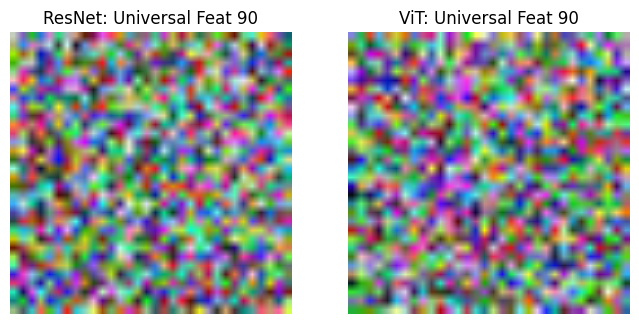

Saved Fig4_Universal_1.png


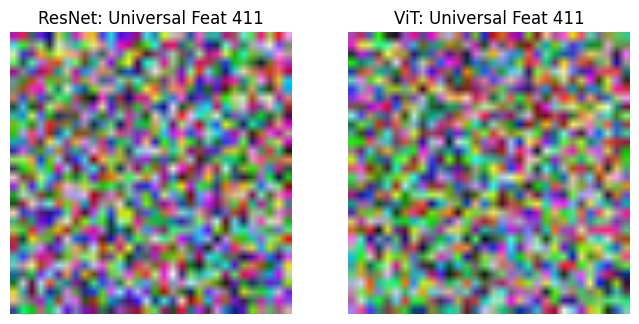

Saved Fig4_Universal_2.png


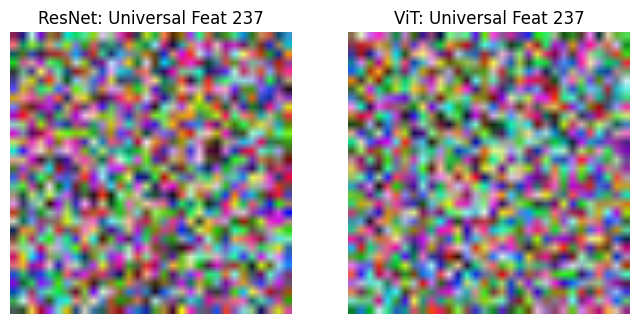

Saved Fig4_Universal_3.png


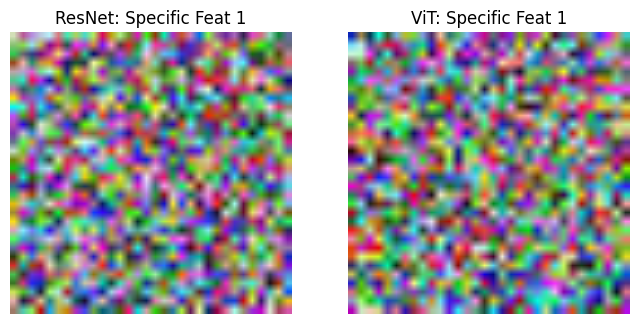

Saved Fig5_Specific.png
ALL TASKS COMPLETE.


In [7]:
# ==========================================
# PHASE 6: VISUALIZATIONS
# [cite: 197-205, 211] 3 Universal + 1 Specific
# ==========================================
print("Generating Visualizations...")

# Swap to Gradient-Safe Hooks for Viz
resnet.layer4._forward_hooks.clear()
vit.encoder.layers.encoder_layer_11._forward_hooks.clear()

class VizHook:
    def __init__(self, model, layer_name):
        self.activations = []
        for name, module in model.named_modules():
            if name == layer_name:
                module.register_forward_hook(self.hook_fn); break
    def hook_fn(self, module, input, output):
        if len(output.shape) == 4: flat = output.mean(dim=[2, 3]) 
        elif len(output.shape) == 3: flat = output[:, 0, :] 
        else: flat = output
        self.activations.append(flat) # No detach!
    def clear(self): self.activations = []

hk_res = VizHook(resnet, "layer4")
hk_vit = VizHook(vit, "encoder.layers.encoder_layer_11")

def generate_dream(feature_idx, filename, title):
    img_res = F.interpolate(torch.rand(1, 3, 32, 32, device=device), size=(224,224), mode='bilinear').requires_grad_(True)
    img_vit = F.interpolate(torch.rand(1, 3, 32, 32, device=device), size=(224,224), mode='bilinear').requires_grad_(True)
    opt = optim.Adam([img_res, img_vit], lr=0.05)
    
    for i in range(150):
        opt.zero_grad()
        # Jitter
        ox, oy = np.random.randint(-3, 4), np.random.randint(-3, 4)
        j_res = torch.roll(img_res, shifts=(ox, oy), dims=(2, 3))
        j_vit = torch.roll(img_vit, shifts=(ox, oy), dims=(2, 3))
        
        hk_res.clear(); hk_vit.clear()
        resnet(j_res); vit(j_vit)
        
        act_res = F.normalize(hk_res.activations[0], p=2, dim=1)
        act_vit = F.normalize(hk_vit.activations[0], p=2, dim=1)
        
        # [cite_start]CAM: Maximize Z [cite: 202-203]
        score = usae.encode(act_res, 0)[0, feature_idx] + usae.encode(act_vit, 1)[0, feature_idx]
        (-score).backward()
        
        # Blur Gradients
        if img_res.grad is not None:
            with torch.no_grad():
                img_res.grad = TF.gaussian_blur(img_res.grad, 5)
                img_vit.grad = TF.gaussian_blur(img_vit.grad, 5)
        opt.step()
        with torch.no_grad(): img_res.data.clamp_(0, 1); img_vit.data.clamp_(0, 1)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    def proc(t): return (t.detach().cpu().squeeze().permute(1,2,0).numpy())
    ax[0].imshow(proc(img_res)); ax[0].set_title(f"ResNet: {title}"); ax[0].axis('off')
    ax[1].imshow(proc(img_vit)); ax[1].set_title(f"ViT: {title}"); ax[1].axis('off')
    plt.savefig(filename); plt.show();plt.close()

# [cite_start]1. Visualize 3 Universal Features [cite: 198]
univ_score = (entropy > 0.8).float() * torch.sqrt(max_act_res * max_act_vit)
top3_vals, top3_inds = torch.topk(univ_score, k=3)

for i, idx in enumerate(top3_inds):
    feat_idx = idx.item()
    generate_dream(feat_idx, f"Fig4_Universal_{i+1}.png", f"Universal Feat {feat_idx}")
    print(f"Saved Fig4_Universal_{i+1}.png")

# [cite_start]2. Visualize 1 Specific Feature [cite: 211]
best_spec = torch.argmin(entropy).item()
generate_dream(best_spec, "Fig5_Specific.png", f"Specific Feat {best_spec}")
print(f"Saved Fig5_Specific.png")

print("ALL TASKS COMPLETE.")